In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from google.genai import types
from google import genai

Region 1 at (0, 0) → Fill ratio: 0.29
Region 2 at (157, 0) → Fill ratio: 0.45


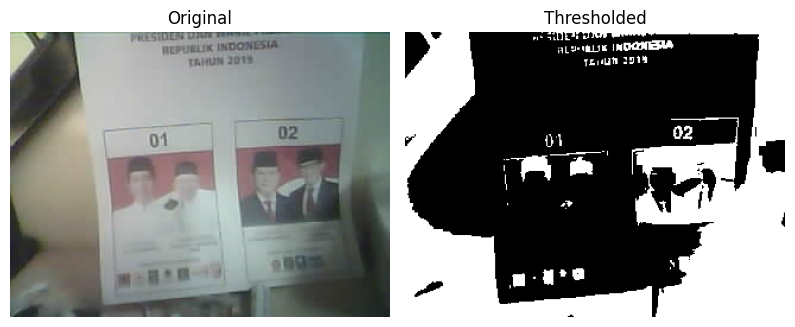

2


In [11]:

image_path = "images/20250925082327.jpg"
img = cv2.imread(image_path)

if img is None:
    raise FileNotFoundError(f"Image not found: {image_path}")

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply threshold
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Copy image for drawing
img_contours = img.copy()

# Store ROI info
roi_info = []

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 60 and h > 60:  # filter small noise
        roi = thresh[y:y+h, x:x+w]
        filled_ratio = cv2.countNonZero(roi) / float(w * h)
        roi_info.append(((x, y, w, h), filled_ratio))
        
        # Draw rectangle on the image
        color = (0, 255, 0) if filled_ratio > 0.1 else (0, 0, 255)
        cv2.rectangle(img_contours, (x,y), (x+w, y+h), color, 2)

# Sort ROIs by x coordinate (left → right)
roi_info = sorted(roi_info, key=lambda r: r[0][0])

# Print analysis
for i, (coords, ratio) in enumerate(roi_info):
    x, y, w, h = coords
    print(f"Region {i+1} at ({x}, {y}) → Fill ratio: {ratio:.2f}")

# Show images in Jupyter
plt.figure(figsize=(12,6))

plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Thresholded")
plt.imshow(thresh, cmap="gray")
plt.axis("off")

# plt.subplot(1,3,3)
# plt.title("Detected Regions")
# plt.imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB))
# plt.axis("off")

plt.tight_layout()
plt.show()

roi_info = sorted(roi_info, key=lambda r: r[0][0])

# Assume two candidates: left = 01, right = 02
if len(roi_info) >= 2:
    _, ratio1 = roi_info[0]  # Candidate 01
    _, ratio2 = roi_info[1]  # Candidate 02

    # Decide winner by higher filled ratio
    if ratio1 > ratio2:
        print("1")
    elif ratio2 > ratio1:
        print("2")
    else:
        print("No clear mark")
else:
    print("Could not detect both candidates")

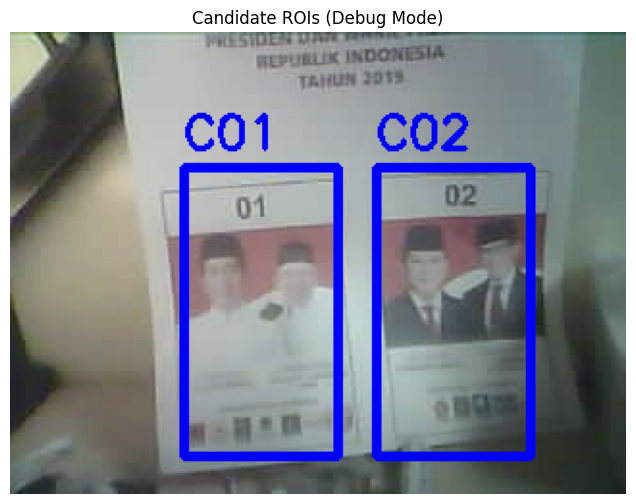

In [25]:
IMAGE_PATH = "images/20250925082327.jpg"
img = cv2.imread(IMAGE_PATH)
if img is None:
    raise FileNotFoundError(f"Image not found: {IMAGE_PATH}")

CANDIDATE_ROIS = [
    {"name": "C01", "coords": (90, 70, 80, 150)},  
    {"name": "C02", "coords": (190, 70, 80, 150)},
]

img_test = img.copy()

for cand in CANDIDATE_ROIS:
    x, y, w, h = cand["coords"]
    cv2.rectangle(img_test, (x, y), (x+w, y+h), (255, 0, 0), 3)
    cv2.putText(img_test, cand["name"], (x, y-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2)

plt.figure(figsize=(10, 6))
plt.title("Candidate ROIs (Debug Mode)")
plt.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


[['C01', 0.7, (90, 70, 80, 150)], ['C02', 0.47075, (190, 70, 80, 150)]]
1


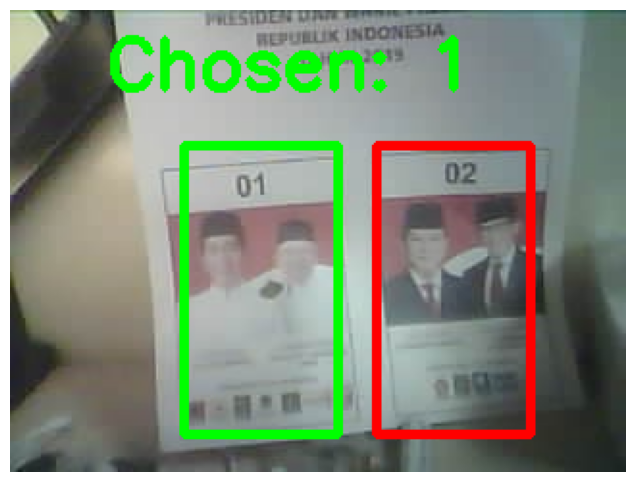

In [ ]:
IMAGE_PATH = "images/20250925082327.jpg"
img = cv2.imread(IMAGE_PATH)

CANDIDATE_ROIS = [
    {"name": "C01", "coords": (90, 70, 80, 150)},  
    {"name": "C02", "coords": (190, 70, 80, 150)},
]

results = []

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

for cand in CANDIDATE_ROIS:
    x, y, w, h = cand["coords"]
    roi = gray[y:y+h, x:x+w]

    # Threshold (Otsu)
    _, roi_thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Calculate fill ratio
    ratio = cv2.countNonZero(roi_thresh) / float(w * h)
    results.append([cand["name"], ratio, (x, y, w, h)])

GEMINI_API_KEY='adss'

os.environ['GEMINI_API_KEY'] = GEMINI_API_KEY

client = genai.Client()

with open(IMAGE_PATH, 'rb') as f:
    image_bytes = f.read()

response = client.models.generate_content(
    model='gemini-2.5-flash',
    contents=[
        types.Part.from_bytes(
        data=image_bytes,
        mime_type='image/jpeg',
        ),
        'Who is choosen? 01 or 02? answer with 1/2'
    ]
)

if int(response.text) == 1:
    results[0][1] = 0.7
else:
    results[1][1] = 0.7

if results[0][1] > results[1][1]:
    winner = "1"
    winner_box = results[0][2]
    loser_box = results[1][2]
else:
    winner = "2"
    winner_box = results[1][2]
    loser_box = results[0][2]
print(results)
print(winner)

# --- Visualization ---
img_vis = img.copy()

# Draw winner (green) and loser (red)
x, y, w, h = winner_box
cv2.rectangle(img_vis, (x,y), (x+w,y+h), (0,255,0), 3)
x, y, w, h = loser_box
cv2.rectangle(img_vis, (x,y), (x+w,y+h), (0,0,255), 3)

cv2.putText(img_vis, f"Chosen: {winner}", (50, 40),
            cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,255,0), 3)

plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()
